# Method development for geometric functions: low-level & E-fields

15/04/20

Aims:

- Add full treatment of E-fields to existing geometric methods.
- Fix/propagate phase conventions cleanly and carefully. NOW SET in geomCalc.setPhaseConventions().

Existing code:

- [Basic E-field generation, propagation & FROG](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons/blob/master/PulseMeasurements/PulseMeasurements_Frog.ipynb)
- Matlab codes for shaped pulses (spherical basis).
- Framework for EPR function in epsproc/geomFuncs, this should accept new E-fields defined here.

Libraries/pkgs which might also be useful:

- [pyNLO](https://pynlo.readthedocs.io/en/latest/readme_link.html), field generation & handling, propagation and NLO interactions.
- Fibre prop code from MPI.

## Basics from FROG code

- [Basic E-field generation, propagation & FROG](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons/blob/master/PulseMeasurements/PulseMeasurements_Frog.ipynb)
- Should also try scipy.spectrogram (and related) functions - likely more robust.

Think this is all that will be required here - want $hv$ per $dt$ for PAD calculations.


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as scipy_constants

For sigma=15: FWHM=35.322, spectral width (transform limit, normalised units)=0.029
For sigma=1.5: FWHM=3.532, spectral width (transform limit, normalised units)=0.293


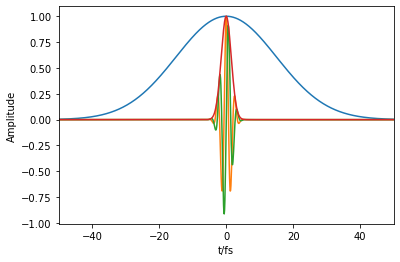

In [2]:
# Define Gaussian pulse in time domain, if carrier freq. is not defined calc. envelope only
# Sigma = Gaussian width, FWHM = 2
def Et(E0,t,sigma,w0=None):
    Efield = E0 * np.exp(-0.5*(t**2)/(sigma**2))
    
    if w0 is not None:
        Efield = Efield * np.exp(1.0j*w0*t)
        
    return Efield

# Define FWHM from sigma
def FWHM(sigma):
    width = 2*np.sqrt(2*np.log(2))*sigma
    dw = 0.44/sigma  # Spectral width for a Gaussian pulse, sigma*tUnit to give in Hz 
    print(f'For sigma={sigma}: FWHM={width:.3f}, spectral width (transform limit, normalised units)={dw:.3f}')
   
    return width

# Define working units
fUnit = 1e12  # THz
lUnit = 1e-9  # nm
tUnit = 1e-15 # fs

# Define temporal axis
dt = 0.1  # Step size for t axis.
t = np.arange(-150,150,dt)

# Gaussian field examples
sig1 = 15
FWHM(sig1)
E1 = Et(1,t,sig1)  # Envelope only, real

sig2 = 1.5
FWHM(sig2)
f0 = 375*fUnit*tUnit  # Carrier freq. in relative units, 375THz = 800nm
E2 = Et(1,t,sig2,w0=f0*2*np.pi)  # Full field, imaginary, w0 defined as angular freq.

plt.plot(t,E1)
plt.plot(t,E2.real,t,E2.imag,t,np.abs(E2))
plt.xlabel('t/fs')
plt.ylabel('Amplitude')
plt.xlim((-50,50))
plt.show()

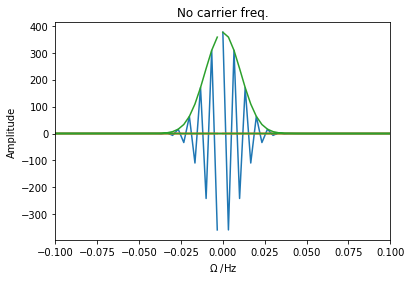

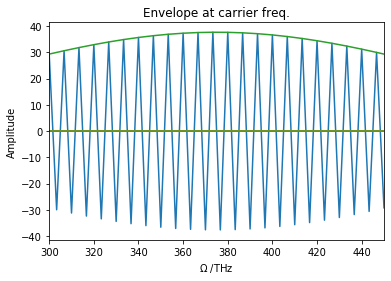

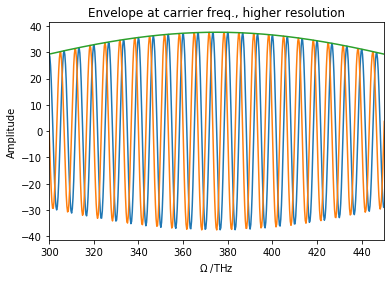

In [3]:
# Define spectral domain pulse as FFT(E(t)). Return normalised freq. axis if t and dt are defined.
# See https://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft for FFT notes.
# For higher-resolution results, add zero-padding

# Define spectral domain pulse as FFT(E(t)). Return normalised freq. axis if t and dt are defined.
def Ew(Et, t=None, dt=None, pad=False):

    Ew = np.fft.fft(Et)

    if t is not None:
        f = np.fft.fftfreq(t.shape[-1],d=dt)
    else:
        f = None

    # Use zero-padding for higher resolution FFT result
    if pad is True:
        n = 2**(np.ceil(np.log2(Et.shape[0]))+3)  
        Ew = np.fft.fft(Et,n=np.int(n)) 

        # New sampling axis
        f = np.fft.fftfreq(np.int(n),d=dt)

    return Ew, f


# FT with unit Hz
E1w, f = Ew(E1,t=t*tUnit,dt=dt)

plt.figure
plt.plot(f,E1w.real,f,E1w.imag, f, np.abs(E1w))
plt.xlim((-dt,dt))
plt.xlabel('$\Omega$ /Hz')
plt.ylabel('Amplitude')
plt.title('No carrier freq.')
plt.show()

# FT with unit THz
E2w, f = Ew(E2,t=t*tUnit,dt=dt*tUnit)

plt.figure
plt.plot(f/fUnit,E2w.real,f/fUnit,E2w.imag, f/fUnit, np.abs(E2w))
plt.xlim((0.8*(f0/tUnit)/fUnit,1.2*(f0/tUnit)/fUnit))
plt.xlabel('$\Omega$ /THz')
plt.ylabel('Amplitude')
plt.title('Envelope at carrier freq.')
plt.show()

# FT with unit Hz, plus zero padding & +ve half of spectrum only
E3w, f3 = Ew(E2,t=t*tUnit,dt=dt*tUnit, pad=True)
# +ve half
E3w = E3w[0:np.int(E3w.shape[0]/2)]
f3 = f3[0:E3w.shape[0]]

plt.figure
plt.plot(f3/fUnit,E3w.real,f3/fUnit,E3w.imag, f3/fUnit, np.abs(E3w))
plt.xlim((0.8*(f0/tUnit)/fUnit,1.2*(f0/tUnit)/fUnit))
plt.xlabel('$\Omega$ /THz')
plt.ylabel('Amplitude')
plt.title('Envelope at carrier freq., higher resolution')
plt.show()

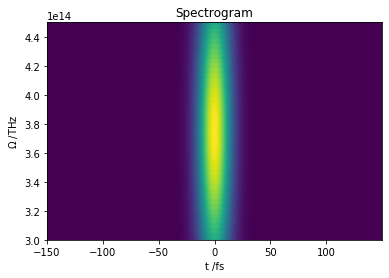

In [4]:
# Frog spectrograms - code adapted from Froglib, https://github.com/xmhk/froglib 
def frog(signal, gate):

    # Following code in froglib...
    nn = len(signal)
    n2 = int(nn / 2)

    # (1) Outer product of two fields (time-domain), blind Frog case
    ap = np.outer(signal, gate)                    

    # (2) Defined empty arrays to hold results
    m1 = np.zeros(np.shape(ap), dtype=np.complex128)
    m2 = np.zeros(np.shape(ap), dtype=np.complex128)

    # (3) Loop over input and roll - effectively sets tau for each row
    for i in range(n2 - 1, -n2, -1):
        m1[i + n2, :] = np.roll(ap[i + n2, :], -i)

    m1 = np.transpose(m1)

    # (4) Roll and FFT to set a freq. axis
    for i in range(nn):
        m2[i, :] = np.roll(np.fft.fft(np.roll(m1[i, :], +n2)), -n2)  # time-freq

    m2 = np.transpose(m2)  # freq - time
    m2 = m2 / np.max(np.max(np.abs(m2)))

    return m2

# Example trace with fields E2 and E2mod
# NOTE field ordering reverses temporal direction in this case.
S = frog(E1,E2)
# S = frog(E2,E2tmod)

plt.figure()
plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
plt.ylim((0.8*(f0/tUnit),1.2*(f0/tUnit)))
plt.ylabel('$\Omega$ /THz')
plt.xlabel('t /fs')
plt.title('Spectrogram')
plt.show()

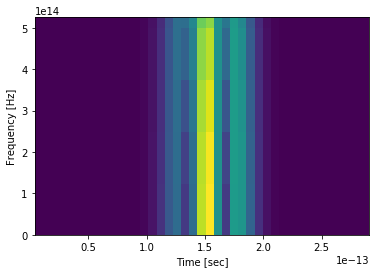

In [5]:
# Test with scipy code
# This will calculate the spectrogram for a single pulse (rather than Frog spectrogram as above), with a selected window function.
# For a Gaussian window this should be the same...
#  - Centered at 0?
#  - Issues with resolution?  Relation between `nperseg` and resolution?
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

from scipy import signal

# Set specific window (default it Tukey)
# For general_gaussian, set power and width
w = ('general_gaussian', 1, 2)

f, t, Sxx = signal.spectrogram(E1, fs = 1/(dt*tUnit), scaling='spectrum', mode = 'magnitude', nperseg = 80, window = w)  # , window = E2)

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim((0*(f0/tUnit),1.4*(f0/tUnit)))
# plt.ylim((0.8*(f0/tUnit),1.2*(f0/tUnit)))
plt.show()

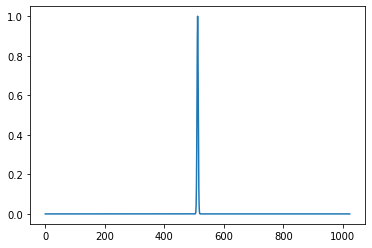

In [6]:
# Check window fn.
window = signal.get_window(w, 1024)
plt.plot(window)
plt.show()

In [7]:
1/tUnit

999999999999999.9

For sigma=15: FWHM=35.322, spectral width (transform limit, normalised units)=0.029


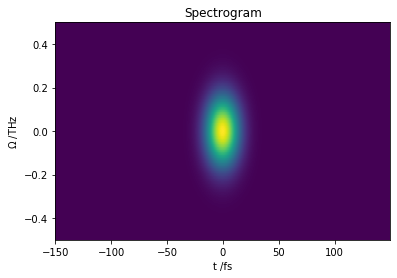

In [8]:
# Test frog spectrogram with window fn.

# Define temporal axis (currently overwritten above)
dt = 0.1  # Step size for t axis.
t = np.arange(-150,150,dt)

# Gaussian field examples
sig1 = 15
FWHM(sig1)
E1 = Et(1,t,sig1)  # Envelope only, real

# FT with unit Hz
E1w, f = Ew(E1,t=t*tUnit,dt=dt)


# Set specific window (default it Tukey)
# For general_gaussian, set power and width
w = ('general_gaussian', 1, 10)


window = signal.get_window(w, E1.size)  # Generate window fn. of correct size.

S = frog(E1, window)

plt.figure()
# plt.imshow(np.abs(S)**2)
plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
# plt.ylim((0.8*(f0/tUnit),1.2*(f0/tUnit)))
# plt.ylim((-0.1*(f0/tUnit),0.1*(f0/tUnit)))
plt.ylim(-0.5, 0.5)
plt.ylabel('$\Omega$ /THz')
plt.xlabel('t /fs')
plt.title('Spectrogram')
plt.show()

For sigma=15: FWHM=35.322, spectral width (transform limit, normalised units)=0.029


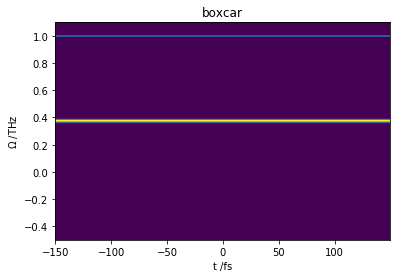

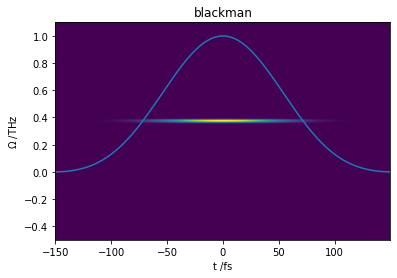

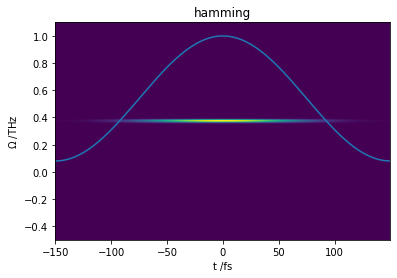

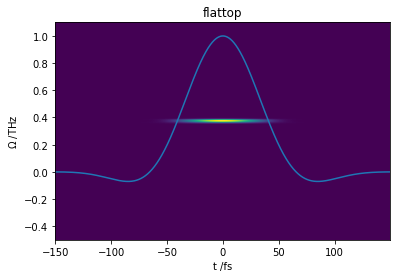

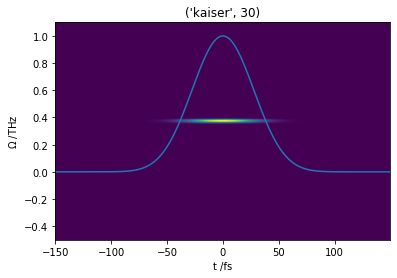

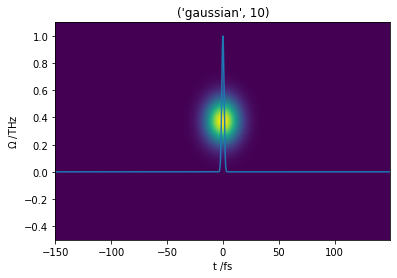

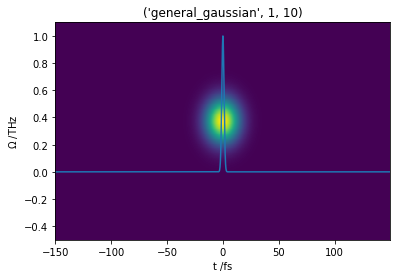

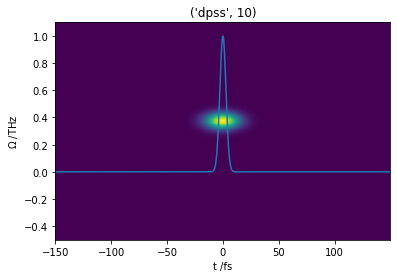

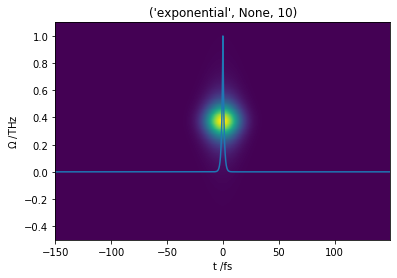

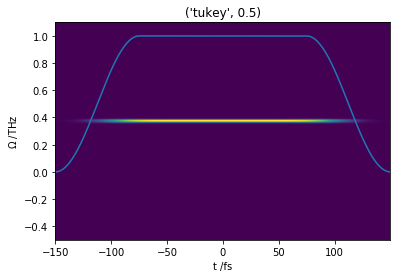

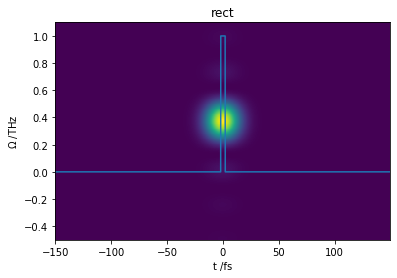

In [9]:
# Test frog spectrogram with window fn. - VARIOUS WINDOWS...

# Define temporal axis (currently overwritten above)
dt = 0.1  # Step size for t axis.
t = np.arange(-150,150,dt)

# Gaussian field examples
sig1 = 15
FWHM(sig1)
E1 = Et(1,t,sig1)  # Envelope only, real

f0 = 375*fUnit*tUnit  # Carrier freq. in relative units, 375THz = 800nm
E1 = Et(1,t,sig1,w0=f0*2*np.pi)  # Full field, imaginary, w0 defined as angular freq.

# FT with unit Hz
E1w, f = Ew(E1,t=t*tUnit,dt=dt)


# Set windows to test, not they may need different params.
# For spectrograms many of these probably aren't useful, since there is no width parameter.
testWindows = ['boxcar', 'blackman', 'hamming', 'flattop', ('kaiser', 30), ('gaussian', 10), ('general_gaussian', 1, 10), ('dpss', 10), ('exponential', None, 10), ('tukey', 0.5), 'rect']


for w in testWindows:
    
    if w == 'rect':  # Define rectangular window, doesn't seem to be in scipy set?  Width in t units
        window = np.ones_like(t)*(np.abs(t)<2)
        
    else:
        window = signal.get_window(w, E1.size)  # Generate window fn. of correct size.

    S = frog(E1, window)

    plt.figure()
    plt.plot(t, window)
    # plt.imshow(np.abs(S)**2)
    plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
    # plt.ylim((0.8*(f0/tUnit),1.2*(f0/tUnit)))
    # plt.ylim((-0.1*(f0/tUnit),0.1*(f0/tUnit)))
    plt.ylim(-0.5, 1.1)
    plt.ylabel('$\Omega$ /THz')
    plt.xlabel('t /fs')
    plt.title(w)
    plt.show()
    
    
    

## Set up E-field class

Combine data + methods, set up Xarray for outputs.

SEE ALSO: `[Stimpy] python\test_codes\E_fields_redux_231118_class.py`
Bit old, but has some unit conversion stuff that might be handy here.

In [10]:
import numpy as np
from scipy import constants as scipy_constants

# Use dictionary to create field defns intially?  Gets confusing otherwise.
# Should be able to iterate/unpack values here for different cases.
# Minimal defn. with (sigma, wavelength) or (bandwidth, wavelength), in working units.
Edef = {'sigma': 15,
        'l0': 800
        }


class Efield():
    '''
    Basic class for handling E-field generation, data and related functions.
    
    Currently set for field creation based on Gaussian defined in time-domain. Defaults to a single (E,t) point if no parameters are supplied - this can be used with :py:func:`epsproc.geomFunc.EPR`

    Define Gaussian field in the time-domain, with amplitude $E_0$, width $\sigma$ and carrier frequency $\omega_0$:

.. math::
    E(\omega_0,t)=E_{0}e^{-(t^2/2\sigma^{2})}e^{i\omega_0 t}

    Carrier frequency in rad/s:

.. math::
    \omega_0 = 2\pi \Omega_0

    FWHM and Gaussian width (see https://en.wikipedia.org/wiki/Gaussian_function for full definitions):

.. math::
    FWHM = 2\sigma\sqrt{2ln2}

    
    Parameters
    ----------
    If no parameters are passed, return single point with E0 = 1
    For a time-dependent field, pass at least sigma.
    
    E0 : float, optional, default = None
        Set (relative) field strength.
        If None, set E0 = 1
        
    sigma : float, optional, default = None
        Set Gaussian width :math:\sigma, where :math:FWHM=2\sigma\sqrt{2ln2}
    
    t : array, optional, default = None
        Set time axis for E-field.
        If None, defaults to np.arange(-(5*sigma), 5*sigma, self.dt), and self.dt = 0.01*sigma
        
    dt : float, optional, default = None
        Set time-step. Default will set from t-axis, or self.dt = 0.01*sigma if sigma only passed. 
        Pass here to override.
        
    l0 : float, optional, default = None
        Central wavelength in wavelength working units.
        If supplied this will be used to set f0 and w0.
    
    f0, w0 : float, optional, default = None
        Carrier frequency in freq. units, and :math:\omega_0 in (rad/s).
        If only f0 supplied, w0 will be calculated. If f0 and w0 supplied, w0 will be used directly.
        If None, this will be ignored.
        
    units : dictionary, optional, default = None
        Set units. If not passed, default dict will be created with units (THz, nm, fs) set.
    
    
    TODO: best way to handle unit conversions?  Did some of this for FROG code already? Yes, see python\test_codes\E_fields_redux_231118_class.py
    
    '''
    
    def __init__(self, Edef = None, E0 = None, sigma = None, A = 1, t = None, dt = None, l0 = None, f0 = None, w0 = None, units = None):
        
        #*** Setup parameters
        # Check for dict-based defns.
        self.Edef = Edef
        if Edef is not None:
            self.unpackEdef()
        
        # Define working units
        self.units = units
        if units is None:
            self.units = {'freq':{'value':1e12, 'unit':'THz'},
                          'len':{'value':1e-9, 'unit':'nm'},
                          'time':{'value':1e-15, 'unit':'fs'}
                         }
        

        # Define temporal axis
        # Set passed values, change to defaults if necessary
        self.sigma = sigma
        self.A = A
        self.dt = dt
        self.t = t
        
        if (self.t is None) and (self.sigma is not None):
            if dt is None:
                self.dt = 0.01*self.sigma  # Step size for t axis, relative to sigma. May get large however!
                
            self.t = np.arange(-(5*self.sigma), 5*self.sigma, self.dt)
        
        # No field in this case, just set to single point
        elif (self.t is None) and (self.sigma is None):
            self.t = [0]
            
        # If t-axis is passed, set dt from this - assumes linear axis
        if (self.t.size > 1) and (self.dt is None):
            self.dt = np.abs(t[1]-t[0])
            
            
        # Set pulse FWHM if defined.
        if self.sigma is not None:
            self.FWHMGau()
        else:
            self.FWHM = None
            
        
        # Set (relative) field strength
        if E0 is None:
            self.E0 = 1
        else:
            self.E0 = E0
            
        # Set wavelength and carrier freq, None case already handled in sub-fns.
        self.l0 = l0
        self.f0 = f0 
        self.w0 = w0
        
        if self.l0 is not None:
            self.f0 = scipy_constants.c/l
        
        if (self.w0 is None) and (self.f0 is not None):
            self.w0 = self.f0 * 2*np.pi * self.units['freq']['value'] * self.units['time']['value']  # w0 in rad/s, converted to relative units
        
        
        #*** Setup field
        if self.dt is None:   # Cases for single point, set as impluse
            self.Et = [1]
            
        else:
            self.Etcalc()
    
    # Unpack E-field defn dict
    def unpackEdef(self):
        for key in self.Edef:
#             self.key = self.Edef
            pass
            
             
    # Define Gaussian pulse in time domain, if carrier freq. is not defined calc. envelope only
    # Sigma = Gaussian width, FWHM = 2
    # Define Gaussian
    def Gau(self):
        g = np.exp(-0.5*self.A*(self.t**2)/(self.sigma**2))
        return g
    
    def Etcalc(self):
        self.Et = self.E0 * self.Gau()

        if self.w0 is not None:
            self.Et = self.Et * np.exp(1.0j*self.w0*self.t)

#         return Efield
    

    # Define FWHM from sigma, for a Gaussian pulse
    def FWHMGau(self):
        self.FWHM = 2*np.sqrt(2*np.log(2))*self.sigma
        self.dw = 0.44/self.sigma  # Spectral width for a Gaussian pulse, sigma*tUnit to give in Hz 
        print(f'For sigma={self.sigma}: FWHM={self.FWHM:.3f}, spectral width (transform limit, normalised units)={self.dw:.3f}')

#         return width

    
    def plot(self):
        '''Basic plot with Matplotlib'''
#         plt.plot(self.t, self.Et)
        plt.plot(self.t, self.Et.real, self.t, self.Et.imag, self.t,np.abs(self.Et))
        plt.xlabel('t/fs')
        plt.ylabel('Amplitude')
        plt.xlim((-50,50))
        plt.legend(['Re', 'Im', 'Abs'])
        plt.show()


In [11]:
Ef = Efield(sigma = 15)

For sigma=15: FWHM=35.322, spectral width (transform limit, normalised units)=0.029


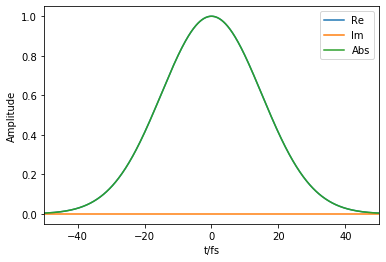

In [12]:
Ef.plot()

For sigma=15: FWHM=35.322, spectral width (transform limit, normalised units)=0.029


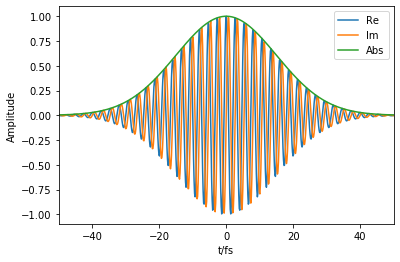

In [13]:
Ef = Efield(sigma = 15, f0 = 375)
Ef.plot()

### Class v2 - move to dicts for all defns.

Allows for more transparent field set-up, and cleaner class structure.

In [14]:
import numpy as np
from scipy import constants as scipy_constants
import pprint

# Use dictionary to create field defns intially?  Gets confusing otherwise.
# Should be able to iterate/unpack values here for different cases.
# Minimal defn. with (sigma, wavelength) or (bandwidth, wavelength), in working units.
# Edef = {'sigma': 15,
#         'l0': 800
#         }


class Efield():
    '''
    Basic class for handling E-field generation, data and related functions.
    
    Currently set for field creation based on Gaussian defined in time-domain. Defaults to a single (E,t) point if no parameters are supplied - this can be used with :py:func:`epsproc.geomFunc.EPR`
    
    Starting to look a bit top-heavy... passing directly to Xarray might save some structural overhead here?

    Define Gaussian field in the time-domain, with amplitude $E_0$, width $\sigma$ and carrier frequency $\omega_0$:

.. math::
    E(\omega_0,t)=E_{0}e^{-(t^2/2\sigma^{2})}e^{i\omega_0 t}

    Carrier frequency in rad/s:

.. math::
    \omega_0 = 2\pi \Omega_0

    FWHM and Gaussian width (see https://en.wikipedia.org/wiki/Gaussian_function for full definitions):

.. math::
    FWHM = 2\sigma\sqrt{2ln2}

    
    Parameters
    ----------
    If no parameters are passed, return single point with E0 = 1
    For a time-dependent field, pass at least sigma.
    
    E0 : float, optional, default = None
        Set (relative) field strength.
        If None, set E0 = 1
        
    sigma : float, optional, default = None
        Set Gaussian width :math:\sigma, where :math:FWHM=2\sigma\sqrt{2ln2}
    
    t : array, optional, default = None
        Set time axis for E-field.
        If None, defaults to np.arange(-(5*sigma), 5*sigma, self.dt), and self.dt = 0.01*sigma
        
    dt : float, optional, default = None
        Set time-step. Default will set from t-axis, or self.dt = 0.01*sigma if sigma only passed. 
        Pass here to override.
        
    l0 : float, optional, default = None
        Central wavelength in wavelength working units.
        If supplied this will be used to set f0 and w0.
    
    f0, w0 : float, optional, default = None
        Carrier frequency in freq. units, and :math:\omega_0 in (rad/s).
        If only f0 supplied, w0 will be calculated. If f0 and w0 supplied, w0 will be used directly.
        If None, this will be ignored.
        
    units : dictionary, optional, default = None
        Set units. If not passed, default dict will be created with units (THz, nm, fs) set.
    
    
    TODO: 
    - best way to handle unit conversions?  Did some of this for FROG code already? Yes, see python\test_codes\E_fields_redux_231118_class.py
    - Consider other structures here, dataclass or namedtuple? https://stackoverflow.com/questions/354883/how-do-i-return-multiple-values-from-a-function
    - Xarray conversion?  Use Xarray directly in class?
    
    '''
    
    def __init__(self, Edef = None, units = None):  # , E0 = None, sigma = None, A = 1, t = None, dt = None, l0 = None, f0 = None, w0 = None, units = None):
        
        #*** Define master list of parameters & init as empty or with defaults
        # If no parameters are passed, this can be used to create a defn template
        self.Edef = {'Pulse' : {'type' : 'Gaussian',   # Eventually should generalise this to allow for other pulse types.
                                'domain' : 't',       # Set a domain label here to switch between (t,E) domain pulse defn. - MAY WANT TO MOVE THIS TO SEPARATE LIST FN?
                                'dfft' : 'f',        # Set conjugate domain (for FFT)
                                'sigma' : None,
                                'E0' : 1,       # Set magnitude of field
                                'CEP':0,        # Set CEP, only used if pulse carrier freq is also defined
                                'A' : 1,        # Set A for Gaussian - should just set as E0?
                                'FWHM' : None,
                                'p' : 0    # Set polarization state. For single values {-1,0,+1} this will just label output. For 'XY' calc. spherical terms.
#                                 'origin' : 0    # Set origin for domain
                               },
                     
                     'Freq' : {'l' : None,   # Set defns. for carrier, (wavelength, freq, ang. freq). Assumed to be in working units. Also use to index units later.
                               'f' : None,
                               'w' : None,
                               # 'CEP':0,        # Set CEP, only used if pulse carrier freq is also defined - SET IN PULSE for now, due to use of assignment loop for Freq terms.
                               # 'Ehv' : None  # Should add here, but need to fix assignment routine first!  Now set by fConv() method.
                               },
                     
                     'Ehv' : {'Ef' : None,  # Defined energy domain to hold field converted to E(hv) units
                              'axis' : None
                             },
                     
                     't' : {'Ef' : None,
                            'axis' : None,    # Set generic labels here to allow for (t,f) axis shared methods.
                            'delta' : None
                               },
                     
                     'f' : {'Ef' : None,
                            'axis' : None,
                            'delta' : None
                               },
                     
#                      'EField' : {'Et' : None,
#                                  'Ef' : None
#                                  },
                     
#                      'Spectrogram' : {'gate' : None,
#                                       'data' : None
#                                      },
                     
                     'Units' : {   # 'f':{'value':1e12, 'unit':'THz'},  # Set this as a derived unit, 1/t, below, otherwise may get discrepancies in unit conversion.
                                'l':{'value':1e-9, 'unit':'nm'},
                                't':{'value':1e-15, 'unit':'fs'},
                                'Ehv':{'value':1, 'unit':'eV'}
                                },
                     
                     # Global FFT settings
                     'FFT' : {'shift':True, 'pad':True, 'positiveHalf':True, 'phaseMaskFlag':False, 'thres':1e-3}
                    }
        
        self.Emod = {'N':0, 0:{}}  # Set empty dict to hold modified fields (propagated, shaped etc.). Use N to hold next field to update value.

        
        # Assign any passed values
        # Skip if no Edef is passed (will just set blank dict)
        if Edef is not None:
            for key in Edef:
                if key in self.Edef:
                    for subkey in Edef[key]:
                        if subkey in self.Edef[key]:
#                             print(f'Setting Item {subkey} in dict {key} to {Edef[key][subkey]}')
                            self.Edef[key][subkey] = Edef[key][subkey]
                        else:
                            print(f'Item {subkey} in dict {key} not recognised.')
                else:
                    print(f'Key {key} not recognised.')
            
            #*** Set working units for conversions
            # Set f units
            self.Edef['Units']['f'] = {'value': np.round(1/self.Edef['Units']['t']['value']), 'unit': f"1/{self.Edef['Units']['t']['unit']}"}  # Derived unit
            
            # Set as Hz in specific cases
            if self.Edef['Units']['f']['value'] == 1e15:
                self.Edef['Units']['f']['unit'] = 'PHz'
            if self.Edef['Units']['f']['value'] == 1e12:
                self.Edef['Units']['f']['unit'] = 'THz'
                
            # Set units for E
            self.Edef['Units']['E'] = self.Edef['Units']['f'].copy()
                
            # Set c in working units
            self.Edef['Units']['c'] = {'value': scipy_constants.c * self.Edef['Units']['t']['value']/self.Edef['Units']['l']['value'],
                                       'unit': f"{self.Edef['Units']['l']['unit']}/{self.Edef['Units']['t']['unit']}"}
#             self.Edef['Units']['c']['value'] = scipy_constants.c * self.Edef['Units']['t']['value'] /self.Edef['Units']['l']['value']
            
            #**** Calculate field and derived properties if set
            self.setEf()
            
            # Set description string - use """ format string, or ""\ multiline
            domain = self.Edef['Pulse']['domain']
            self.Estring = f"""{self.Edef['Pulse']['type']} pulse: $\sigma$={self.Edef['Pulse']['sigma']} {self.Edef['Units'][domain]['unit']}, FWHM={self.Edef['Pulse']['FWHM']:.3f} {self.Edef['Units'][domain]['unit']},
l0={self.Edef['Freq']['l']:.3f} (dl={self.Edef['Pulse']['dl']:.3f}) {self.Edef['Units']['l']['unit']},  
f0={self.Edef['Freq']['f']:.3f} (df={self.Edef['Pulse']['dw']:.3f}) {self.Edef['Units']['f']['unit']} 
(bandwidths for Gaussian transform limited pulses)"""

            # Print summary details
            self.printDef()
        

    def printDef(self):
        print('Pulse properties dictionary set:')
        pp = pprint.PrettyPrinter(indent=4)
        
        # Print defns.
        for key in ['Pulse', 'Freq', 'Units', 'FFT']:
            print(f'{key} settings:')
            pp.pprint(self.Edef[key])
            
        # Print domain details
        for key in [self.Edef['Pulse']['domain'], self.Edef['Pulse']['dfft']]:
            if self.Edef[key]['Ef'] is not None:
                print(f'{key} domain settings:')
                print(f"Points = {len(self.Edef[key]['Ef'])}, delta = {self.Edef[key]['delta']}")
            else:
                print(f"{key} domain not set")
        
        # Print field details
        for key in ['EField', 'Spectrogram']:
            pass
        
        
    def setEf(self):
        """
        Calculate pulse properties and E-fields based on Edef.
        """

        # Set pulse in time-domain
        if self.Edef['Pulse']['domain'] == 't':

            # Set pulse FWHM or sigma if defined.
            # If both values are preset, only sigma is used.
            if (self.Edef['Pulse']['sigma'] is not None) and (self.Edef['Pulse']['type'] == 'Gaussian'):
                self.FWHMGau()
            elif(self.Edef['Pulse']['FWHM'] is not None) and (self.Edef['Pulse']['type'] == 'Gaussian'):
                self.sigmaGau()

            # Set t axis if required
            if (self.Edef['t']['axis'] is None) and (self.Edef['Pulse']['sigma'] is not None):

                if self.Edef['t']['delta'] is None:
                    self.Edef['t']['delta'] = 1e-3*self.Edef['Pulse']['sigma']  # Default step size for t axis, relative to sigma. May get large however!

                self.Edef['t']['axis'] = np.arange(-(5*self.Edef['Pulse']['sigma']), 5*self.Edef['Pulse']['sigma'], self.Edef['t']['delta'])

            # No pulse in this case, just set to single point (t=0)
            elif (self.Edef['t']['axis'] is None) and (self.Edef['Pulse']['sigma'] is None):
                self.Edef['t']['axis'] = [0]

            # If t-axis is passed, set dt from this - assumes linear axis
            # Use length here to allow for list or np.array types
            if (len(self.Edef['t']['axis']) > 1) and (self.Edef['t']['delta'] is None):
                self.Edef['t']['delta'] = np.abs(self.Edef['t']['axis'][1]-self.Edef['t']['axis'][0])
                
                
            # Check and set carrier freq if set
            if any(self.Edef['Freq'].values()):
                # Check which value is set, and set missing values.
                # Neater/slicker way to do this? Recursively?
                for key in self.Edef['Freq']:  
                    if self.Edef['Freq'][key] is not None:
                        refKey = key
                        refValue = self.Edef['Freq'][key]
                        print(refValue)
                        
                if refKey is 'w':
                    refValue *= self.Edef['Units']['f']['value']/2*np.pi

# TODO: set for Ehv case.
#                 if refKey is 'Ehv':
#                     refValue *= self.Edef['Units']['f']['value']/2*np.pi
                    
#                 else:
                
#                 refValue *= self.Edef['Units'][refKey]['value']  # Convert to real units - not required if c in working units
                    
                for key in self.Edef['Freq']:
                    if key not in [refKey, 'w']:
#                         self.Edef['Freq'][key] = (scipy_constants.c/refValue)/self.Edef['Units'][key]['value']  # Convert between wavelength and freq., and set to working units
                        self.Edef['Freq'][key] = self.Edef['Units']['c']['value']/refValue  # With c in working units
                        
                if refKey is not 'w':  # Set w0 in working units (rad/[unit t])
#                     self.Edef['Freq']['w'] = 2*np.pi * self.Edef['Freq']['f'] * self.Edef['Units']['f']['value'] * self.Edef['Units']['t']['value']
                    self.Edef['Freq']['w'] = 2*np.pi * self.Edef['Freq']['f']


            self.ECalc()   # Set defined field
            self.EFFT()    # Set FFT field
            
            # Set fields in Emod too - may eventually replace above with this?
            for key in [self.Edef['Pulse']['domain'], self.Edef['Pulse']['dfft']]:
                self.Emod[self.Emod['N']][key] = self.Edef[key]
            
            self.Emod['N'] += 1
            


    #***************** Basic generators
            
    # Define Gaussian pulse in time domain, if carrier freq. is not defined calc. envelope only
    # Sigma = Gaussian width, FWHM = 2
    # Define Gaussian
    def Gau(self):
#             g = np.exp(-0.5*self.Edef['Pulse']['A']*(self.Edef['t']['axis']**2)/(self.Edef['Pulse']['sigma']**2))
#         g = np.exp(-0.5*self.Edef['Pulse']['A']*((self.Edef[self.Edef['Pulse']['domain']]['axis']/self.Edef['Pulse']['sigma'])**2))
        g = np.exp(-0.5*self.Edef['Pulse']['A']*(self.Edef[self.Edef['Pulse']['domain']]['axis']**2)/(self.Edef['Pulse']['sigma']**2))
        
        return g

    # Define FWHM from sigma, for a Gaussian pulse
    def FWHMGau(self):
        self.Edef['Pulse']['FWHM'] = 2*np.sqrt(2*np.log(2))*self.Edef['Pulse']['sigma']
        self.Edef['Pulse']['dw'] = 0.44/self.Edef['Pulse']['sigma']  # Spectral width for a Gaussian pulse, working units, sigma*tUnit to give in Hz 
                                                                     # This is a bit of a fudge - need to decide where to put dw, and E domain defn.
            
        if self.Edef['Freq']['l'] is not None:
            self.Edef['Pulse']['dl'] = (self.Edef['Pulse']['dw']*self.Edef['Freq']['l']**2)/self.Edef['Units']['c']['value']
#             self.Edef['Pulse']['dl'] = ((self.Edef['Pulse']['dw']*self.Edef['Freq']['l']**2)/scipy_constants.c)  # Spectral width in wavelength units
#         print(f"For sigma={self.Edef['Pulse']['sigma']}: FWHM={self.Edef['Pulse']['FWHM']:.3f}, spectral width (transform limit)={self.Edef['Pulse']['dw']:.3f}")

    # Set field based on defined pulse parameters
    def ECalc(self):
        
        domain = self.Edef['Pulse']['domain']
        
        self.Edef[domain]['Ef'] = self.Edef['Pulse']['E0'] * self.Gau()

        if (self.Edef['Freq']['w'] is not None) and (domain == 't'):  # Only valid for t-domain defn.
#             print('OK')
#             print(self.Edef['Freq']['w'])
#             print(self.Edef[domain]['axis'])
#             print(np.exp(1.0j*self.Edef['Freq']['w']*self.Edef[domain]['axis']))
#             self.Edef[domain]['Ef'] = self.Edef[domain]['Ef'] * np.exp(1.0j*self.Edef['Freq']['w']*self.Edef[domain]['axis']/self.Edef['Units'][domain]['value'])  
#             self.Edef[domain]['Ef'] = self.Edef[domain]['Ef'] * np.exp(1.0j*self.Edef['Freq']['w']*self.Edef[domain]['axis']*self.Edef['Units'][domain]['value'])  
            self.Edef[domain]['Ef'] = self.Edef[domain]['Ef'] * np.exp(1.0j*(self.Edef['Freq']['w']*self.Edef[domain]['axis'] - self.Edef['Pulse']['CEP']))  
      
    
    #********************* FT functions
    
    # Set other domain field as FFT
    # Define spectral domain pulse as FFT(E(t)). Return normalised freq. axis if t and dt are defined.
    def EFFT(self): #, pad = True, positiveHalf = True, phaseMaskFlag = False, thres = 1e-3):  # Now set in dict.

        domain = self.Edef['Pulse']['domain']
        dfft = self.Edef['Pulse']['dfft']
        
        # Use zero-padding for higher resolution FFT result?
        if self.Edef['FFT']['pad'] is True:
            n = np.int(2**(np.ceil(np.log2(self.Edef[domain]['Ef'].shape[0]))+3))
            nAxis = n
        else:
            n = None # Default value to pass to np.fft for no padding
            nAxis = self.Edef[domain]['axis'].shape[-1]
     
        Ebar = np.fft.fft(self.Edef[domain]['Ef'], n=n)   # No fft shift, axis [0 .... +ve .... -ve], see https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html?highlight=fft
        axis = np.fft.fftfreq(nAxis, d=self.Edef[domain]['delta'])
    
        if self.Edef['FFT']['shift']:
            Ebar = np.fft.fftshift(Ebar)   # Apply fft shift to move 0 to centre of range
            axis = np.fft.fftshift(axis)

        # Set for full or half FT
        if self.Edef['FFT']['positiveHalf']:
            if self.Edef['FFT']['shift']:
                inds = np.arange(np.int(Ebar.shape[0]/2), Ebar.shape[0])   # Set for half the range, starting from centre
            else:
                inds = np.arange(0, np.int(Ebar.shape[0]/2))   # Set for half the range, starting at 0
                
            self.Edef[dfft]['Ef'] = Ebar[inds]
            self.Edef[dfft]['axis'] = axis[inds]
            self.Edef[dfft]['delta'] = axis[1]-axis[0]
            
        else:
            self.Edef[dfft]['Ef'] = Ebar
            self.Edef[dfft]['axis'] = axis
            self.Edef[dfft]['delta'] = axis[1]-axis[0]
            
        if self.Edef['FFT']['phaseMaskFlag']:
            self.phaseMask(domain = dfft)
    
    
#     # Function for checking for modified fields & sorting
#     def checkEmod(self):
# #         # Loop over domains
# #         for domain in [self.Edef['Pulse']['domain'], self.Edef['Pulse']['dfft']]:
        
# #             # Check for existing mod fields
# #             if domain in self.Emod.keys():
# #                 N = list(self.Emod[domain].keys())
        
# #         # Should change formatting here, may want domain_N to allow for multiple cases, and looping.
# #         if (domain + '_mod') in self.Edef.keys():
# #             N = list(self.Edef[domain + '_mod'].keys())
# #         else: 
# #             self.Edef[domain + '_mod'] = {}
# #             N = 0

#         # Check if entries exist
#         if self.Emod:
#             N = self.Emod.N
#         else:
#             N = 0
            
#         # Set 
    
    # Calculate iFFT(E).
    # This, sort of, assumes that the field is defined as E(w), and the spectral phase is modified.
    # But could be used for other cases.
    # Emod is used if passed, otherwise uses self.Edef[dfft]['Ef']
    # 27/04/20 Modified to use self.Emod for fields.
    # In this case, send either Emod to use this directly, or Ninput to use self.Emod[Ninput].
    # Set comment = '' to pass notes on field generation.
    def EiFFT(self, Emod = None, Ninput = None, comment = ''): #, f=None, pad=False):
        
        domain = self.Edef['Pulse']['domain']
        dfft = self.Edef['Pulse']['dfft']
        
        Nlast = self.Emod['N'] - 1  # Most recent field index, use this as input if nothing else specified
        
        # Set field based on input - this is currently a bit ugly!
#         if (Emod is None) and (Ninput is None):
#             if dfft in self.Emod[Nlast]:
#                 Emod = self.Emod[Nlast][dfft]['Ef']   # Default to most recent field if it exists
#                 EmodAxis = self.Emod[Nlast][dfft]['axis']
#             else:
#                 Emod = self.Edef[dfft]['Ef']  # Revert to original field defn. if not supplied
#                 EmodAxis = self.Edef[dfft]['axis']
        
#         elif (Emod is None) and (Ninput is not None):  # Set specific field from Emod
#             Emod = self.Emod[Ninput][dfft]['Ef']
#             EmodAxis = self.Emod[Ninput][dfft]['axis']
        
        # Rewrite for updated Emod dict.
        N = Nlast  # Set default
        if Ninput is not None:
            N = Ninput
        
        if Emod is None:
            Emod = self.Emod[N][dfft]['Ef']   # Default to most recent field if it exists
            EmodAxis = self.Emod[N][dfft]['axis']

            if 'comment' in self.Emod[N][dfft].keys():
                comment += self.Emod[N][dfft]['comment']  # Propagate comment
        
        # Transform back to time-domain, and center
        Eifft = np.fft.ifftshift(np.fft.ifft(Emod))   # With shift
#         Eifft = (np.fft.ifft(self.Edef[dfft]['Ef']))  # Without shift

        if self.Edef['FFT']['positiveHalf']:  # Correct amplitudes, get x2 otherwise if positiveHalf is True.
            Eifft /= 2.0

#         self.Edef[domain]['Ef'] = np.c_[self.Edef[domain]['Ef'], Eifft]   # Basic stacking OK if pad=False and positiveHalf=False, otherwise axis lengths different

        # Set for full or half FT - if used with iFFT shift and a pulse center at 0, this will slice result.
        inds = np.int(Eifft.shape[0])   # Set for full range
#         if self.Edef['FFT']['positiveHalf']:
#             inds = np.int(Eifft.shape[0]/2)   # Set for half the range

#         # Set as new field, or as new dict?
#         # Should change formatting here, may want domain_N to allow for multiple cases, and looping.
#         if (domain + '_mod') in self.Edef.keys():
#             N = list(self.Edef[domain + '_mod'].keys())
#         else: 
#             self.Edef[domain + '_mod'] = {}
#             N = 0
        
        # Set pair of fields in output
        # Always set to new output, or check for pair...?
        if domain in self.Emod[Nlast]:  # If conjugate domain is already set, create a new field pair...
            Noutput = Nlast + 1
            self.Emod[Noutput] = {}
            self.Emod[Noutput][dfft] = {'Ef':Emod,
                                        'axis':EmodAxis,
                                        'domain':domain   
                                        }
        else:
            Noutput = Nlast  # ...otherwise use input index.
            
        self.Emod[Noutput][domain] = {'Ef':Eifft[0:inds],
                                      'axis':np.fft.ifftshift(np.fft.fftfreq(Eifft.shape[-1], d=self.Edef[dfft]['delta'])[0:inds]),
                                      'domain':domain,
                                      'comment':comment  # Add passed comment here, may also want to autogenerate note on field source?
                                    
                                    }
    
        
        
        #if f:
        #    t = np.fft.ifftfreq(f.shape[-1])
        #else:
        #    t = None

    # TODO
    def finst(self):
        """Calculate f(t) as instantaneous freq."""
        print('Not impemented')

        
    #*************** Phase modification fns.
    # TODO: add more sophisticated fns, see, e.g., froglib.phasemanipulations, for removing linear and phase offsets.
    
    # Mask phase away from pulse?
    def phaseMask(self, domain = None, thres = None):
        """Mask pulse phase away from main features.  Should convert to use masked arrays for reversibility, or just return a mask (currently overwrites Ef)."""
        
        if thres is None:
            thres = self.Edef['FFT']['thres']  # Use global thres if not passed.
        
        thres = thres * np.abs(self.Edef[domain]['Ef']).max()
        
        self.Edef[domain]['Ef'][np.abs(self.Edef[domain]['Ef']) < thres] = 0  # Basic mask to zero away from features
#         self.Edef[domain]['Ef'][np.abs(self.Edef[domain]['Ef']) < thres] = np.nan  # Set as NaNs - will remove points from plots, but also throws errors with np.angle()
        
    
    def setPhase(self, phaseVec = None, domain = None):
        """Set imaginary field terms (set phase) for specified domain & recalculated FFT."""
        
        # Example: set quadratic phase
        # Set quadratic phase (corresponds to linear chirp), phi=A*f^2
        # A = 0.1/fUnit
        # Ewq = np.abs(E2w)*np.exp(1.0j*(A*(f-(f0/tUnit)))**2)
        
        # Transform back to time-domain
        # E2tmod = np.fft.ifftshift(np.fft.ifft(Ewq))
        
        pass
        # TODO: impement, and add original & modified field placeholders. Or set as new rows in Ef array?
        
        
    
    def removePhase(self, domain = None):
        """Remove imaginary field terms (reset phase)."""
        
        if domain is None:
            for item in ['t', 'f']:
                self.Edef[item]['Ef'] = np.abs(self.Edef[item]['Ef'])
        else:
            self.Edef[domain]['Ef'] = np.abs(self.Edef[domain]['Ef'])
      
    

    def chirp(self, A, resetPhase=True, comment = None):
        """    
        Add quadratic phase (chirp) in spectral domain. Requires an E-field object, and chirp parameter A.
        
        .. :math: phi=A*(f-f0)^2
        
        TODO: check Diels for nomenclature here.
        
        """
        domain = 'f'
        
        Nlast = self.Emod['N']  # Last output slot, use N-1 as input if nothing else specified
        
        # Set field - checks no longer required as now Emod[0] set at init (in setEf()).
#         try:
#             Ew = self.Emod[Nlast-1][domain]['Ef']  
#             EwAxis = self.Emod[Nlast-1][domain]['axis']  
#         except KeyError:
#             Ew = self.Edef[domain]['Ef']
#             EwAxis = self.Edef[domain]['axis']  
        
        Ew = self.Emod[Nlast-1][domain]['Ef']  
        EwAxis = self.Emod[Nlast-1][domain]['axis']  
        
        
        # Remove existing phase - this is only the linear term if starting from a Gaussian pulse
        if resetPhase:
            Ew = np.abs(Ew)
        
        # Add chirp
#         Ewq = np.abs(Ew)*np.exp(1.0j*(A*(self.Edef[domain]['axis']-self.Edef['Freq']['f']))**2)
        Ewq = Ew*np.exp(1.0j*A*(self.Edef[domain]['axis']-self.Edef['Freq']['f'])**2)

        
        # Set as new field, or as new dict?
        # Should change formatting here, may want domain_N to allow for multiple cases, and looping.
        # Or nest this? Or concatenate? (-- Only if domain axes are identical.)
#         if (domain + '_mod') in self.Edef.keys():
#             N = list(self.Edef[domain + '_mod'].keys())
#         else: 
#             self.Edef[domain + '_mod'] = {}
#             N = 0
            
#         self.Edef[domain + '_mod'][N] = {'Ef':Ewq,
#                                      'axis':self.Edef[domain]['axis'],
#                                      'domain':domain
                                     
#                                     }

        self.Emod[Nlast] = {}
        self.Emod[Nlast][domain] = {'Ef':Ewq,
                                     'axis':EwAxis,
                                     'domain':domain,
                                     'comment': f'$E_{{{Nlast-1}}}$, phase {domain} chirped, A={A}',
                                     'A':A
                                    }

        self.Emod['N'] += 1  # Update indexer
        
#         self.EiFFT(Emod = Ewq)  # Set tmod pulse via ifft
        self.EiFFT()  # Set tmod pulse via ifft
        

    #***************** Spectrograms
    
    # Basic (Frog) spectrograms - code adapted from Froglib, https://github.com/xmhk/froglib 
    # For code implementing various Frog methods, see "E_fields_redux_231118_class.py" - to be implemented here as frog() method
    def calcSpectrogram(self, signal = None, gate = None):
        
        domain = 't'
        
        # Set signal and gate fields. If not passed, use most recently set fields.
        N = self.Emod['N'] - 1
        
        if signal is None:
            signal = self.Emod[N][domain]['Ef']
        
        elif type(signal) is np.ndarray:
            pass
        
#         elif type(signal) is   ####### May want to allow for passing of pulse defn. dictionary here?
        
        gateObj = None
        
        if gate is None:
            gate = signal   # Default to signal, or to short gaussian...?
        
        elif type(gate) is float:   # Take a passed value as a Gaussian width...?
            pass
        
        elif type(gate) is dict:  # Generate gate pulse as new Ef object
            gateObj = Efield(gate)
            gate = gateObj.Edef[domain]['Ef']
            
#         elif type(signal) is np.ndarray:
#             pass
        
        # TODO:
        # - Error checking, currently needs square array.
        # - Downsampling for cases with large FFT axis - just select ROI around features (see Frog code?)
        # - Methods, see "E_fields_redux_231118_class.py" for more frog types.

        # Following code in froglib...
        nn = len(signal)
        n2 = int(nn / 2)

        # (1) Outer product of two fields (time-domain), blind Frog case
        ap = np.outer(signal, gate)                    

        # (2) Defined empty arrays to hold results
        m1 = np.zeros(np.shape(ap), dtype=np.complex128)
        m2 = np.zeros(np.shape(ap), dtype=np.complex128)

        # (3) Loop over input and roll - effectively sets tau for each row
        for i in range(n2 - 1, -n2, -1):
            m1[i + n2, :] = np.roll(ap[i + n2, :], -i)

        m1 = np.transpose(m1)

        # (4) Roll and FFT to set a freq. axis
        for i in range(nn):
            m2[i, :] = np.roll(np.fft.fft(np.roll(m1[i, :], +n2)), -n2)  # time-freq

        m2 = np.transpose(m2)  # freq - time
        m2 = m2 / np.max(np.max(np.abs(m2)))

#         return m2

        # Set outputs - should just set in Emod....?
        self.Spectrogram = {'siganl':signal,
                            'gate':gate,
                            'gateObj':gateObj,
                            'data':m2
                            'N':N
                           }

    
    #***************** Derived domains/unit conversion
    
    # Set other domains via copy & rescale - would be neater just to store multiple axes, but duplicate for now.
    def fConv(self):
        """Convert freq. domain axis to lenght & energy units. and set fields."""
        
        domain = 'f'
        
        for N in np.arange(0, self.Emod['N']):
            
            # Set wavelength scale
            self.Emod[N]['l'] = self.Emod[N][domain].copy()   # Without .copy() this will just be a pointer.
            self.Emod[N]['l']['axis'] = self.Edef['Units']['c']['value']/self.Emod[N]['f']['axis']
            
            # Set energy scale
            self.Emod[N]['Ehv'] = self.Emod[N][domain].copy()
            self.Emod[N]['Ehv']['axis'] = (scipy_constants.h/scipy_constants.e) * self.Emod[N]['f']['axis']/self.Edef['Units']['t']['value']
        

    
    #***************** Plotting
    
    # Basic plotting
    # TODO: check plotTypes vs. defns. in ePSproc
    # TODO: modify to plot sets of fields, either stacked or single plot.
    # 28/04/20: Changed to plot from Emod[N] dicts
    # TODO: sort out axis limits - should pass to override or set in class. Also change to, e.g. Holoviews, for more interaction...
    def plot(self, plotType = 'phaseUW', Nplot = None, domainList = None, thres = 1e-2):
        '''Basic plot with Matplotlib'''
#         plt.plot(self.t, self.Et)
        
        if Nplot is None:
            Nplot = np.arange(0, self.Emod['N'])
            
        # Default plots for domain + dfft
        if domainList is None:
            domainList = [self.Edef['Pulse']['domain'], self.Edef['Pulse']['dfft']]
    
        for domain in domainList:
            # Set up figure - do this *before* looping over N (fields)
            fig, ax1 = plt.subplots()
            if plotType == 'phaseUW':
                ax2 = ax1.twinx()
            
#             lText = []
            
            # Plot selected fields
            for N in Nplot:
                lString = f'$E_{{{N}}}$ '
                
                # Plot according to type
                if plotType == 'complex':
                    # Plot real + imag field components
                    ax1.plot(self.Emod[N][domain]['axis'], self.Emod[N][domain]['Ef'].real, '-', label = lString + 'Re')
                    ax1.plot(self.Emod[N][domain]['axis'], self.Emod[N][domain]['Ef'].imag, '-', label = lString + 'Im')
                    ax1.plot(self.Emod[N][domain]['axis'], np.abs(self.Emod[N][domain]['Ef']), '--', label = f'|{lString}|')
#                     plt.legend(['Re', 'Im', 'Abs'])
#                     lText.extend([f'{N} Re', f'{N} Im', f'{N} Abs'])

                elif plotType == 'field':
                    # Plot real-valued field (E + E*)
                    ax1.plot(self.Emod[N][domain]['axis'], 0.5*(self.Emod[N][domain]['Ef'] + self.Emod[N][domain]['Ef'].conj()), '-', label = f'{lString}+{lString}*')
                

                elif plotType == 'abs':
                    # Plot envelope only, |E|
                    ax1.plot(self.Emod[N][domain]['axis'], np.abs(self.Emod[N][domain]['Ef']), '-', label = f'|{lString}|')
            

                elif plotType == 'phase':
                    # Plot magnitude + phase
                    ax1.plot(self.Emod[N][domain]['axis'], np.abs(self.Emod[N][domain]['Ef']),'-', label = f'|{lString}|')
                    ax1.plot(self.Emod[N][domain]['axis'], (np.angle(self.Emod[N][domain]['Ef'])), '--', label = lString + 'Phase')
#                     lText.extend([f'{N} Abs', f'{N} Phase'])
#                     lText.extend((f'{N} Abs', f'{N} Phase'))
#                     ax1.legend(['Abs', 'Phase'])

                elif plotType == 'phaseUW':
                    # Plot magnitude + phase, unwrapped

                    # Single axis
    #                 plt.plot(self.Edef[domain]['axis'], np.abs(self.Edef[domain]['Ef']), self.Edef[domain]['axis'], np.unwrap(np.angle(self.Edef[domain]['Ef'])))

                    # Test secondary_y - not working
    #                 plt.plot(self.Edef[domain]['axis'], np.abs(self.Edef[domain]['Ef']))
    #                 plt.plot(self.Edef[domain]['axis'], np.unwrap(np.angle(self.Edef[domain]['Ef'])), secondary_y=True)

                    # Full ax addressing
                    ax1.plot(self.Emod[N][domain]['axis'], np.abs(self.Emod[N][domain]['Ef']), '-', label = f'|{lString}|')
                    ax2.plot(self.Emod[N][domain]['axis'], np.unwrap(np.angle(self.Emod[N][domain]['Ef'])), '--', label = lString + 'Phase')

#                     plt.legend(['Abs', 'Phase (unwrapped)'])
#                     lText.extend([f'{N} Abs', f'{N} Phase'])
#                     lText.extend((f'{N} Abs', f'{N} Phase'))

                    
            if plotType != 'phaseUW':
                plt.ylabel('Amplitude')
                plt.xlabel(self.Edef['Units'][domain]['unit'])

            else:
                ax1.set_ylabel('Amplitude')
                ax2.set_ylabel('Phase (unwrapped)')
                ax1.set_xlabel(self.Edef['Units'][domain]['unit'])


        #         plt.xlim((-2.66, 2.66))  # Set for two cycles at 800nm
    #             plt.xlim(-0.5, 0.5)

            # Set some sensible limits (FFT scales will be large)
            if domain == 'f':  # self.Edef['Pulse']['dfft']:  # Hmmm, should be able to do this generically over all domains?  With origin + width?
                                                                # TODO: move origins + widths to domain-specific containers.
                plt.xlim(0.8*self.Edef['Freq']['f'], 1.2*self.Edef['Freq']['f'])
            
            elif domain == 't':
                scale = [-2.5, 2.5]
                plt.xlim(scale[0]*self.Edef['Pulse']['FWHM'], scale[1]*self.Edef['Pulse']['FWHM'])
                
            else:
                # Estimate from feature...
                peak = np.abs(self.Emod[N][domain]['Ef']).max()
                mask = np.abs(self.Emod[N][domain]['Ef']) > peak*thres
                scale = [self.Emod[N][domain]['axis'][mask].min(), self.Emod[N][domain]['axis'][mask].max()]
                plt.xlim(scale[0], scale[1])

            # Set legend from array or list
#             plt.legend(Nplot)
#             plt.legend(lText)
            
            # Set legends from labels, per axis object
            if plotType == 'phaseUW':
                ax1.legend(loc='upper left')
                ax2.legend(loc='upper right')
            else:
                ax1.legend(loc='upper left')  # This sometimes defaults to middle, so set explicitly
    
    
            plt.title(self.Estring + f'\nplotType = {plotType}') 
            plt.show()

            
    def plotSpectrogram(self):
        """VERY basic spectrogram plotter from old code - for quick testing only."""
        
        # Testing - set vars as per old code for brevity
        S = self.Spectrogram['data']
        N = self.Emod['N'] - 1
        t = self.Emod[N]['t']['axis']
        f = self.Emod[N]['f']['axis']
        
        plt.figure()
        plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
        plt.ylim((1.5*(f0/tUnit),2.5*(f0/tUnit)))
        plt.ylabel('$\Omega$ /THz')
        plt.xlabel('t /fs')
        plt.title('Spectrogram')
        plt.show()

SyntaxError: invalid syntax (<ipython-input-14-5f93b5d627c4>, line 655)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Edef = {'Pulse':{'sigma':15}, 'Freq':{'l':800}}  # Works
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'l':800}, 't':{'delta':0.1}}
Edef = {'Pulse':{'sigma':2, 'CEP':np.pi}, 'Freq':{'l':800}, 't':{'delta':0.01}, 'FFT':{'positiveHalf':True, 'pad':True}}
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'l':700}}
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'f':374.7405724999999*1e-3}}  # Missing complex field????  Terms are 10^-12, looks like tUnit issue, but output w is identical to working l=800 case???
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'f':374.7405724999999}, 't':{'delta':0.1}}
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'f':700}}
# Edef = {'Pulse':{'sigma':15}, 'Freq':{'w':2354.564459136066}}  # Works, aside from unit conversion

# WEIRD - for identical 'w', seems to have different renorm for t-axis depending if set from l or f - must be accidental unit swap somewhere?
# AH - sampling issue. V. sensitive to f/w values, with dt=1 can just end up with zeros.
# BUT - now complex field is showing significant dt dependence... which is clearly wrong!
# Could it be an array memory issue somewhere???? Something weird seems to be going on....

Ef = Efield(Edef)
# pp.pprint(Ef.Edef)
# Ef.Edef

In [ ]:
print(Ef.Estring)

In [ ]:
Ef.plot(plotType='field')

In [ ]:
Ef.plot(plotType='phaseUW')
# Ef.plot(plotType='complex')

Hmmm - time-domain looks good, not sure about FFT yet - different oscillations from previous test case?  Units or plotting issue somewhere...?

In [ ]:
# Ef.removePhase()
Ef.plot()

In [ ]:
Ef.EiFFT()

In [ ]:
# plt.plot(np.abs(Ef.Edef['tmod']['Ef']))
# plt.plot(Ef.Edef['t_mod'][0]['axis'], np.abs(Ef.Edef['t_mod'][0]['Ef']))
# plt.xlim((-80, 80))

In [ ]:
# Test chirp fn.
# Ef.chirp(A = 1e-11*Ef.Edef['Units']['f']['value'])
Ef.chirp(A = 100, resetPhase = False)  # With A=0 get x2 intensity enhancement... not quite right...! AH - depends on E(t) FFT > if positiveHalf get x2 amplitudes here, OK otherwise. Now added /2 into EiFFT function.

In [ ]:
# plt.plot(Ef.Edef['tmod']['axis'], np.abs(Ef.Edef['tmod']['Ef']))
plt.plot(Ef.Emod[0]['t']['axis'], np.abs(Ef.Emod[0]['t']['Ef']))   # Now working with Emod dict - just need to change plotting fn. to loop over this too.
#************* ACTUALLY, should just set N=0 as unmodified fields, then easy to loop over!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.plot(Ef.Emod[1]['t']['axis'], np.abs(Ef.Emod[1]['t']['Ef']))   # Now working with Emod dict - just need to change plotting fn. to loop over this too.
plt.plot(Ef.Edef['t']['axis'], np.abs(Ef.Edef['t']['Ef']))
plt.xlim((-80, 80))
plt.legend(('Modified','Original'))

In [ ]:
Ef.plot(plotType='complex')

In [ ]:
Ef.plot(plotType='phaseUW')

In [ ]:
Ef.plot(plotType = 'abs')

In [ ]:
Ef.plot(plotType = 'field')

In [ ]:
# Test alternative units
Ef.fConv()

Ef.plot(plotType = 'abs', domainList = ['l','Ehv'])

### Testing spectrogram routines

In [ ]:
# Ef.calcSpectrogram()  # Basic routine should take signal x signal, with last modified field.
Ef.calcSpectrogram(gate = Edef)

In [ ]:
# Testing - set vars as per old code for brevity
# Seems to be working, but issues with scale - not sure if it's calc problem, or just plotting.  2x800nm, 375THz == 400nm, 749THz... but seem to hit 649 or 915THz - must be f axis issue?
# Ah, yes - not sure how to set correct f-axis when zero-padding has been applied.
# If using FFT fields only, then axis dims match, but v..e...r...y slow (8192x8192 in test case, which isn't really that big!!!)
S = Ef.Spectrogram['data']
N = Ef.Emod['N'] - 1
t = Ef.Emod[N]['t']['axis']
f = Ef.Emod[N]['f']['axis']

plt.figure()
# plt.imshow(np.abs(S)**2)
# plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
# plt.imshow(np.abs(S)**2, extent = [t[0],t[-1],f[np.int(S.shape[0]/2)-1],f[np.int(S.shape[0]/2)]], aspect='auto')
# plt.imshow(np.abs(S)**2, extent = [t[0],t[-1], f[0], f[np.int(S.shape[0]/2)-1]], aspect='auto')
# plt.imshow(np.abs(S)**2, extent = [t[0],t[-1], f[np.int(S.shape[0]/2)-1], f[0]], aspect='auto')
plt.imshow(np.abs(S)**2, extent = [t[0],t[-1], f[np.int(S.shape[0]/2)-1], f[0]], aspect='auto')
# plt.ylim((1.5*(f0/tUnit),2.5*(f0/tUnit)))
# plt.ylim(0.7*(f0),1.5*(f0))
# plt.ylim(2*Ef.Edef['Freq']['f'] - 2*Ef.Edef['Pulse']['dw'], 2*Ef.Edef['Freq']['f'] + 2*Ef.Edef['Pulse']['dw'])
# plt.ylim(0.3, 0.4)
plt.ylabel('$\Omega$ /THz')
plt.xlabel('t /fs')
plt.title('Spectrogram')
plt.show()

In [ ]:
# Check with old plotting routine

Ef.plotSpectrogram()

### Test plotting subroutines

In [ ]:
N = 1
domain = 't'
self = Ef
fig, ax1 = plt.subplots()

ax1.plot(self.Emod[N][domain]['axis'], self.Emod[N][domain]['Ef'].real, label = f'{N} Re')
ax1.plot(self.Emod[N][domain]['axis'], self.Emod[N][domain]['Ef'].imag, label = f'{N} Im')
ax1.plot(self.Emod[N][domain]['axis'], np.abs(self.Emod[N][domain]['Ef']), label = f'{N} Abs')

plt.legend()
plt.show()

### Test Xarray functions

In [ ]:
# Test Xarray conversion...
import xarray as xr

N = 0
domain = 't'
test = xr.DataArray(Ef.Emod[N][domain]['Ef'], coords=[(domain,Ef.Emod[N][domain]['axis'])])

In [ ]:
test

In [ ]:
ds = xr.Dataset(Ef.Emod[0]['t'])  # This sort-of works... but get both Ef and axis as data vars

In [ ]:
ds

In [ ]:
# Dataset manual form, set {name:(dims,data,attribs)} and associated coords.
# http://xarray.pydata.org/en/stable/data-structures.html#creating-a-dataset

N = 0
domain = 't'
dfft = 'f'

ds = xr.Dataset({'time':([domain], Ef.Emod[N][domain]['Ef']),
                 'freq':([dfft], Ef.Emod[N][dfft]['Ef'])},
                 coords = {'t':Ef.Emod[N][domain]['axis'],
                           'f':Ef.Emod[N][dfft]['axis']})
ds

In [ ]:
# With spectrogram - assumes axis sizes are concomittant I think

N = 1
domain = 't'
dfft = 'f'

ds = xr.Dataset({'Et':([domain], Ef.Emod[N][domain]['Ef']),
                 'Ef':([dfft], np.fft.fftshift(Ef.Emod[N][dfft]['Ef'])),   # Use fftshift here IF ALSO SET for f axis below.
                 'spectrogram': ([dfft, domain], np.abs(Ef.Spectrogram['data']))},  # Set abs here for easy plotting, but should use xr.pipe or hv functions (http://holoviews.org/user_guide/Transforming_Elements.html)
                 coords = {'t':Ef.Emod[N][domain]['axis'],
                           'f':np.fft.fftshift(Ef.Emod[N][dfft]['axis'])})   # FFtshift here to get Xarray spectrogram plotting working correctly - does this shift axis at all...?
#                            'f':(Ef.Emod[N][dfft]['axis'])})

# Set units (will be used for plotting)
ds[domain].attrs['units'] = Ef.Edef['Units'][domain]['unit']
ds['E' + domain].attrs['units'] = 'arb'
ds[dfft].attrs['units'] = Ef.Edef['Units'][dfft]['unit']
ds['E' + dfft].attrs['units'] = 'arb'

# Add derived units - may want these set as domains in original class structure?
# ds.coords['l'] = (('f'), Ef.Edef['Units']['c']['value']/ds.coords['f'])
# ds.coords['Ehv'] = (('f'), (scipy_constants.h/scipy_constants.e) * ds.coords['f']/Ef.Edef['Units']['t']['value'])

ds

In [ ]:
# With spectrogram + looping over domains - assumes axis sizes are concomittant I think

N = 0

ds = xr.Dataset()  # Init empty dataset, then loop over fields

for domain in Ef.Emod[N].keys():
    
    domainName = f'E{domain}'  # Set data name - can't be same as coord names in this case
    
    if domain in [Ef.Edef['Pulse']['domain'], Ef.Edef['Pulse']['dfft']]:  # Key dims, set as unlinked
        ds[domainName] = ((domain), Ef.Emod[N][domain]['Ef'])
        ds.coords[domain] = Ef.Emod[N][domain]['axis']
    
    else:
        ds[domainName] = ((domain), Ef.Emod[N][domain]['Ef'])
        ds.coords[domain] = ((Ef.Edef['Pulse']['dfft']), Ef.Emod[N][domain]['axis'])  # For derived dims, set as linked to dfft dim - should set this more cleanly elsewhere...?
        

    # Set units (will be used for plotting)
    ds[domain].attrs['units'] = Ef.Edef['Units'][domain]['unit']
    ds[domainName].attrs['units'] = 'arb'
    
# Assign spectrogram
if hasattr(Ef, 'Spectrogram'):
    ds['spectrogram'] = ((Ef.Edef['Pulse']['dfft'], Ef.Edef['Pulse']['domain']), np.abs(Ef.Spectrogram['data']))
   
# Add derived units - may want these set as domains in original class structure?
# ds.coords['l'] = (('f'), Ef.Edef['Units']['c']['value']/ds.coords['f'])
# ds.coords['Ehv'] = (('f'), (scipy_constants.h/scipy_constants.e) * ds.coords['f']/Ef.Edef['Units']['t']['value'])

ds

In [ ]:
ds.coords['Ehv'].plot()

In [ ]:
# Currently appearing at f0, not 2xf0, probably fft axis issue again...
# Ah, working for chirped pulse... must be pulse defn. issue then?
ds['spectrogram'].pipe(np.abs).plot()
plt.ylim(0.7, 0.8)

plt.figure()
ds['Et'].pipe(np.abs).plot()

plt.figure()
ds['Ef'].pipe(np.abs).plot()
plt.xlim(0.3, 0.6)

In [ ]:
# Try Seaborn... https://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns

# sns.jointplot()
g = sns.JointGrid(x=Ef.Emod[N][domain]['axis'], y=np.fft.fftshift(Ef.Emod[N][dfft]['axis']), data=np.abs(Ef.Spectrogram['data']), space=0)
# HMMMM doesn't work - looks like this needs two 1D functions, not a 2D array?
# Same for KDE plot routine: https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot

In [ ]:
# Actually, go for holoviews...
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

hv_ds = hv.Dataset(ds['spectrogram'])
hv_ds

In [ ]:
spec = hv_ds.to(hv.Image, kdims=['t','f'])
spec.opts(width=700, height=700)